**Import necessary libraries**

In [16]:

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances as cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import random
from tqdm import tqdm
import time
import os

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

**Loading Save Models**

In [14]:
# Load the dataset
df = pd.read_csv('zomato_cleaned_features.csv', header=None)
# Define column names based on the data structure we can see
columns = ['name', 'rate', 'approx_cost(for two people)', 'has_online_delivery', 'has_table_booking', 
           'votes', 'cuisines', 'rest_type', 'location', 'combined_features',
           'has_online_delivery_encoded', 'has_table_booking_encoded', 
           'standardized_rating', 'standardized_cost', 'standardized_votes']
df.columns = columns

# Convert numerical columns to appropriate types
df['rate'] = pd.to_numeric(df['rate'], errors='coerce')
df['approx_cost(for two people)'] = pd.to_numeric(df['approx_cost(for two people)'], errors='coerce')
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')

# Load the saved models
def load_model(model_path):
    with open(model_path, 'rb') as f:
        return pickle.load(f)

# Load models
cosine_model = load_model('cosine_similarity.pkl')
knn_model = load_model('knn.pkl')
kmeans_model = load_model('kmeans.pkl')

print("Models loaded successfully!")
print(f"Cosine model keys: {list(cosine_model.keys())}")
print(f"KNN model keys: {list(knn_model.keys())}")
print(f"KMeans model keys: {list(kmeans_model.keys())}")

Models loaded successfully!
Cosine model keys: ['feature_matrix', 'scaler', 'restaurant_data', 'numerical_columns']
KNN model keys: ['knn_model', 'scaler', 'feature_columns', 'restaurant_data']
KMeans model keys: ['kmeans_model', 'scaler', 'feature_columns', 'cluster_labels', 'optimal_k', 'centroids_original_scale']


**Cosine Similarity**

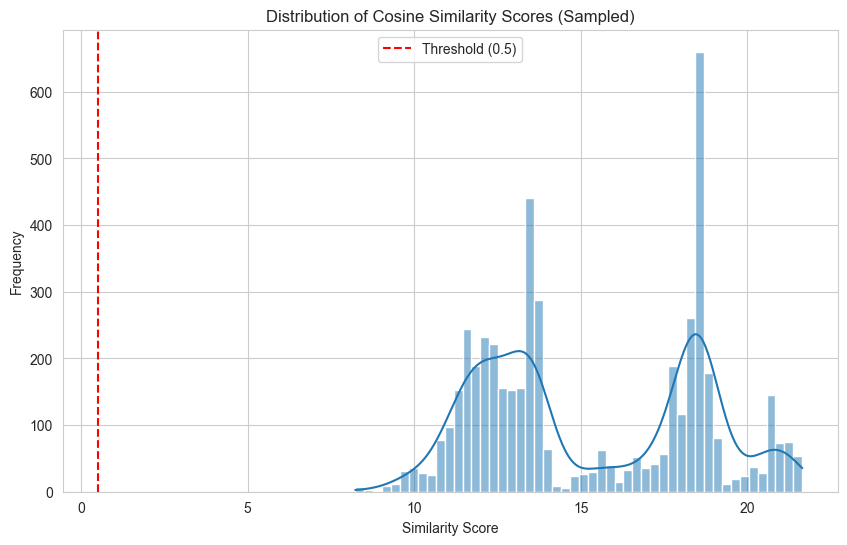

Mean similarity: 15.3078
Median similarity: 13.7948
Std deviation: 3.2989
Min similarity: 8.2314
Max similarity: 21.6524
Proportion of high similarity (>=0.5): 1.0000


In [17]:
# --- SIMILARITY SCORE ANALYSIS ---

# Extract feature matrix from cosine model
feature_matrix = cosine_model['feature_matrix']

# Function to compute similarity scores on-demand
def get_similarity_scores(restaurant_idx, k=100):
    """Compute similarity scores for a given restaurant index"""
    query_vec = feature_matrix[restaurant_idx].reshape(1, -1)
    # Compute cosine similarity with all restaurants
    sim_scores = cosine_similarity(query_vec, feature_matrix)[0]
    # Get top k similar (excluding self)
    top_indices = np.argsort(sim_scores)[::-1][1:k+1]
    return list(zip(top_indices, sim_scores[top_indices]))

# Analyze distribution of similarity scores for a sample of restaurants
sample_size = min(100, len(feature_matrix))  # Limit to 100 for efficiency
sample_indices = np.random.choice(len(feature_matrix), sample_size, replace=False)
all_similarities = []

for idx in sample_indices:
    sim_scores = get_similarity_scores(idx, k=50)  # Get top 50 similarities
    all_similarities.extend([score for _, score in sim_scores])

# Analyze distribution of similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title('Distribution of Cosine Similarity Scores (Sampled)')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.show()

# Calculate statistics
print(f"Mean similarity: {np.mean(all_similarities):.4f}")
print(f"Median similarity: {np.median(all_similarities):.4f}")
print(f"Std deviation: {np.std(all_similarities):.4f}")
print(f"Min similarity: {np.min(all_similarities):.4f}")
print(f"Max similarity: {np.max(all_similarities):.4f}")
print(f"Proportion of high similarity (>=0.5): {(np.array(all_similarities) >= 0.5).mean():.4f}")

**Analyzing Recommendation from Cosine_Similarity**

Original Restaurant: Unicorn Bar & Restaurant
Cuisines: Seafood, North Indian, Chinese
Location: Infantry Road
Rating: 3.9
Cost for two: 800.0

Top Recommendations:
1. The Hidden Home
   Similarity: 21.5746
   Cuisines: Asian, Chinese, Continental, North Indian, South Indian
   Location: Sarjapur Road
   Rating: 4.2, Cost for two: 1300.0

2. La Casa Brewery And Kitchen
   Similarity: 21.5746
   Cuisines: Finger Food, Continental, Seafood
   Location: Sarjapur Road
   Rating: 4.4, Cost for two: 1500.0

3. The Black Pearl
   Similarity: 20.9874
   Cuisines: North Indian, European, Mediterranean, BBQ
   Location: Marathahalli
   Rating: 4.8, Cost for two: 1500.0

4. W XYZ Bar - Aloft Bengaluru Cessna Business Park
   Similarity: 20.9874
   Cuisines: Finger Food, North Indian
   Location: Bellandur
   Rating: 3.8, Cost for two: 2000.0

5. The Hidden Home
   Similarity: 20.9874
   Cuisines: Asian, Chinese, Continental, North Indian, South Indian
   Location: Sarjapur Road
   Rating: 4.3, Co

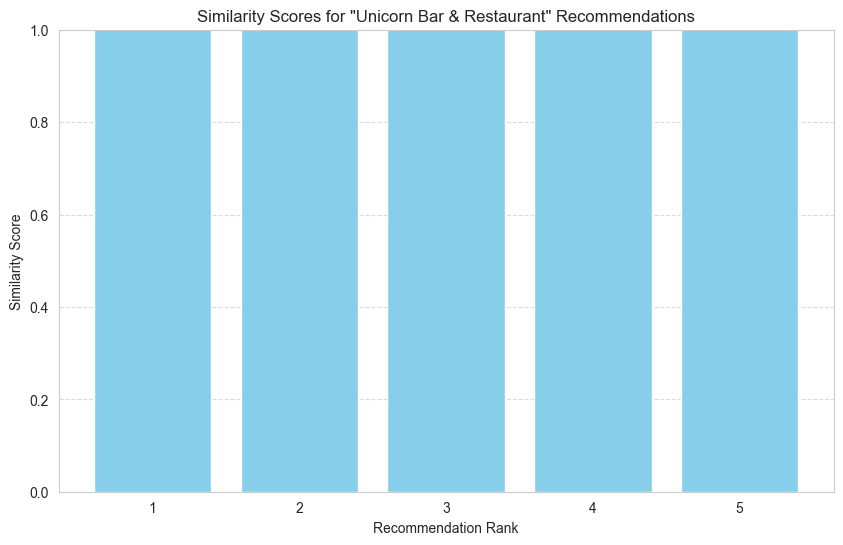

In [18]:
def analyze_recommendations(restaurant_name, n_recommendations=5):
    """Analyze recommendations for a specific restaurant"""
    # Get the restaurant
    restaurant_indices = df[df['name'].str.contains(restaurant_name, case=False, na=False)].index.tolist()
    
    if not restaurant_indices:
        print(f"Restaurant '{restaurant_name}' not found.")
        return
    
    restaurant_idx = restaurant_indices[0]
    restaurant = df.iloc[restaurant_idx]
    
    # Get recommendations using on-demand similarity calculation
    sim_scores = get_similarity_scores(restaurant_idx, k=n_recommendations+1)
    
    # Create recommendations dataframe
    rec_indices = [i[0] for i in sim_scores[:n_recommendations]]
    similarity_scores = [i[1] for i in sim_scores[:n_recommendations]]
    recommendations = df.iloc[rec_indices].copy()
    recommendations['similarity'] = similarity_scores
    
    # Print analysis
    print(f"Original Restaurant: {restaurant['name']}")
    print(f"Cuisines: {restaurant['cuisines']}")
    print(f"Location: {restaurant['location']}")
    print(f"Rating: {restaurant['rate']}")
    print(f"Cost for two: {restaurant['approx_cost(for two people)']}")
    print("\nTop Recommendations:")
    
    for i, (_, rec) in enumerate(recommendations.iterrows(), 1):
        print(f"{i}. {rec['name']}")
        print(f"   Similarity: {rec['similarity']:.4f}")
        print(f"   Cuisines: {rec['cuisines']}")
        print(f"   Location: {rec['location']}")
        print(f"   Rating: {rec['rate']}, Cost for two: {rec['approx_cost(for two people)']}")
        print()
    
    # Visualize similarity scores
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, n_recommendations+1), similarity_scores, color='skyblue')
    plt.xlabel('Recommendation Rank')
    plt.ylabel('Similarity Score')
    plt.title(f'Similarity Scores for "{restaurant_name}" Recommendations')
    plt.xticks(range(1, n_recommendations+1))
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Analyze recommendations for a specific restaurant
analyze_recommendations("Unicorn Bar & Restaurant")

In [20]:
def create_evaluation_set(n_users=20, n_holdout=3):
    """
    Create an evaluation set by holding out some restaurants for each user.
    In this context, we'll treat each restaurant as a "user" of similar restaurants.
    """
    evaluation_set = []
    
    # Randomly select restaurants to evaluate
    sampled_indices = random.sample(range(len(df)), n_users)
    
    for idx in sampled_indices:
        restaurant = df.iloc[idx]
        
        # Get all potential similar restaurants (based on location and cuisine)
        similar_restaurants = df[
            (df['location'] == restaurant['location']) & 
            (df['cuisines'].str.contains(restaurant['cuisines'].split(',')[0], case=False, na=False, regex=False))
        ].index.tolist()
        
        # Skip if not enough similar restaurants
        if len(similar_restaurants) <= n_holdout + 1:
            continue
        
        # Remove the restaurant itself from similar restaurants
        similar_restaurants = [i for i in similar_restaurants if i != idx]
        
        # Randomly select holdout items
        holdout = random.sample(similar_restaurants, min(n_holdout, len(similar_restaurants)))
        
        evaluation_set.append({
            'restaurant_idx': idx,
            'restaurant_name': restaurant['name'],
            'relevant_items': holdout
        })
    
    return evaluation_set

# Create evaluation set
evaluation_set = create_evaluation_set(n_users=30, n_holdout=3)
print(f"Created evaluation set with {len(evaluation_set)} restaurants to evaluate")

# Define recommendation functions for each model that work with the actual model structure
def cosine_recommend(restaurant, n=5):
    """Get recommendations using cosine similarity model"""
    # Find the restaurant index
    restaurant_indices = df[df['name'].str.contains(restaurant, case=False, na=False, regex=False)].index.tolist()
    if not restaurant_indices:
        return df.nlargest(n, 'votes')[['name']]
    
    idx = restaurant_indices[0]
    sim_scores = get_similarity_scores(idx, k=n+1)
    
    # Convert to proper format
    return df.iloc[[i[0] for i, _ in sim_scores]][:n][['name']]

def knn_recommend(restaurant, n=5):
    """Get recommendations using KNN model"""
    # Find the restaurant index
    restaurant_indices = df[df['name'].str.contains(restaurant, case=False, na=False, regex=False)].index.tolist()
    if not restaurant_indices:
        return df.nlargest(n, 'votes')[['name']]
    
    idx = restaurant_indices[0]
    
    # Get KNN model components
    if 'knn' in knn_model:
        knn = knn_model['knn']
    else:
        # If KNN model was saved differently
        feature_matrix = knn_model['feature_matrix']
        knn = NearestNeighbors(n_neighbors=n+1, metric='cosine')
        knn.fit(feature_matrix)
    
    # Get neighbors
    distances, indices = knn.kneighbors([feature_matrix[idx]], n_neighbors=n+1)
    
    # Convert to proper format (skip the first item which is the restaurant itself)
    return df.iloc[indices[0][1:]][['name']]

def kmeans_recommend(restaurant, n=5):
    """Get recommendations using KMeans model"""
    # Find the restaurant index
    restaurant_indices = df[df['name'].str.contains(restaurant, case=False, na=False, regex=False)].index.tolist()
    if not restaurant_indices:
        return df.nlargest(n, 'votes')[['name']]
    
    idx = restaurant_indices[0]
    
    # Get cluster label for the restaurant
    if 'cluster_labels' in kmeans_model:
        cluster = kmeans_model['cluster_labels'][idx]
    else:
        # If cluster labels weren't saved, compute them
        kmeans = kmeans_model['kmeans']
        cluster = kmeans.predict([feature_matrix[idx]])[0]
    
    # Get all restaurants in the same cluster
    if 'cluster_labels' in kmeans_model:
        cluster_indices = np.where(kmeans_model['cluster_labels'] == cluster)[0]
    else:
        cluster_indices = np.where(kmeans.predict(feature_matrix) == cluster)[0]
    
    # Sort by similarity within cluster
    if len(cluster_indices) > 1:
        # Compute similarities within the cluster
        query_vec = feature_matrix[idx].reshape(1, -1)
        cluster_features = feature_matrix[cluster_indices]
        similarities = cosine_similarity(query_vec, cluster_features)[0]
        sorted_indices = np.argsort(similarities)[::-1]
        # Skip the first item (which is the restaurant itself if present)
        if idx in cluster_indices:
            result_indices = [cluster_indices[i] for i in sorted_indices[1:min(n+1, len(sorted_indices))]]
        else:
            result_indices = [cluster_indices[i] for i in sorted_indices[:min(n, len(sorted_indices))]]
    else:
        # If only one restaurant in cluster, return random recommendations
        result_indices = np.random.choice(len(df), min(n, len(df)), replace=False)
    
    return df.iloc[result_indices][['name']]


Created evaluation set with 30 restaurants to evaluate


In [26]:
# ===========================
# 2. EVALUATION METRICS SETUP
# ===========================

def precision_at_k(recommended_items, relevant_items, k):
    """Calculate precision at k"""
    if not recommended_items or not relevant_items:
        return 0.0
    recommended_at_k = recommended_items[:k]
    relevant_recommended = len(set(recommended_at_k) & set(relevant_items))
    return relevant_recommended / min(k, len(recommended_at_k)) if min(k, len(recommended_at_k)) > 0 else 0

def recall_at_k(recommended_items, relevant_items, k):
    """Calculate recall at k"""
    if not recommended_items or not relevant_items:
        return 0.0
    recommended_at_k = recommended_items[:k]
    relevant_recommended = len(set(recommended_at_k) & set(relevant_items))
    return relevant_recommended / len(relevant_items) if relevant_items else 0

def f1_score_at_k(recommended_items, relevant_items, k):
    """Calculate F1 score at k"""
    if not recommended_items or not relevant_items:
        return 0.0
    p = precision_at_k(recommended_items, relevant_items, k)
    r = recall_at_k(recommended_items, relevant_items, k)
    return 2 * (p * r) / (p + r) if (p + r) > 0 else 0

def ndcg_at_k(recommended_items, relevant_items, k):
    """Calculate NDCG at k"""
    if not recommended_items or not relevant_items:
        return 0.0
    
    # Create relevance scores (1 if relevant, 0 otherwise)
    relevance = [1 if item in relevant_items else 0 for item in recommended_items[:k]]
    
    # Calculate DCG
    dcg = sum([rel / np.log2(i+2) for i, rel in enumerate(relevance)])
    
    # Calculate IDCG (ideal DCG)
    ideal_relevance = [1] * min(len(relevant_items), k) + [0] * max(0, k - len(relevant_items))
    idcg = sum([rel / np.log2(i+2) for i, rel in enumerate(ideal_relevance)])
    
    return dcg / idcg if idcg > 0 else 0

def coverage(recommendations, total_items):
    """Calculate coverage as percentage of unique items recommended"""
    if not recommendations:
        return 0.0
    unique_recommended = set()
    for rec_list in recommendations:
        unique_recommended.update(rec_list)
    return len(unique_recommended) / total_items

def diversity(recommendations):
    """Calculate diversity of recommendations (simplified version)"""
    if not recommendations:
        return 1.0
    all_items = [item for sublist in recommendations for item in sublist]
    return 1 - (len(all_items) - len(set(all_items))) / len(all_items) if len(all_items) > 0 else 1

# ===================================
# 3. MODEL-SPECIFIC RECOMMENDATION FUNCTIONS (FIXED)
# ===================================

# Extract feature matrices with proper error handling
cosine_feature_matrix = None
knn_feature_matrix = None

if cosine_model and 'feature_matrix' in cosine_model:
    cosine_feature_matrix = cosine_model['feature_matrix']
    print(f"Cosine feature matrix shape: {cosine_feature_matrix.shape}")

if knn_model:
    if 'feature_matrix' in knn_model:
        knn_feature_matrix = knn_model['feature_matrix']
        print(f"KNN feature matrix shape: {knn_feature_matrix.shape}")
    elif 'scaler' in knn_model and 'restaurant_data' in cosine_model:
        # Reconstruct feature matrix if needed
        print("Reconstructing KNN feature matrix...")
        # This would require the original numerical columns - skipping for now

# Cosine Similarity model recommendation function
def cosine_recommend(restaurant_name, n_recommendations=5):
    """Get recommendations using cosine similarity model"""
    if cosine_feature_matrix is None:
        # Fallback to random recommendations
        return random.sample(range(len(df)), min(n_recommendations, len(df)))
    
    # Find matching restaurants (case-insensitive partial match)
    try:
        restaurant_indices = df[df['name'].str.contains(restaurant_name, case=False, na=False, regex=False)].index.tolist()
        
        if not restaurant_indices:
            # Return top restaurants by votes if no match found
            return df.nlargest(n_recommendations, 'votes').index.tolist()
        
        # Use first match
        idx = restaurant_indices[0]
        
        # Compute cosine similarity with all restaurants
        query_vec = cosine_feature_matrix[idx].reshape(1, -1)
        sim_scores = cosine_similarity(query_vec, cosine_feature_matrix)[0]
        
        # Get top N similar (excluding self)
        top_indices = np.argsort(sim_scores)[::-1][1:n_recommendations+1]
        
        return top_indices.tolist()
    except Exception as e:
        print(f"Error in cosine_recommend for {restaurant_name}: {str(e)}")
        return random.sample(range(len(df)), min(n_recommendations, len(df)))

# KNN model recommendation function
def knn_recommend(restaurant_name, n_recommendations=5):
    """Get recommendations using KNN model"""
    # Find matching restaurants
    try:
        restaurant_indices = df[df['name'].str.contains(restaurant_name, case=False, na=False, regex=False)].index.tolist()
        
        if not restaurant_indices:
            return df.nlargest(n_recommendations, 'votes').index.tolist()
        
        # Use first match
        idx = restaurant_indices[0]
        
        # Check if we have a trained KNN model
        if knn_model and 'knn' in knn_model and knn_feature_matrix is not None:
            # Get neighbors
            distances, indices = knn_model['knn'].kneighbors([knn_feature_matrix[idx]], n_neighbors=n_recommendations+1)
            # Return indices (skip the first item which is the restaurant itself)
            return indices[0][1:].tolist()
        else:
            # Fallback to cosine similarity if KNN model is not properly loaded
            return cosine_recommend(restaurant_name, n_recommendations)
    except Exception as e:
        print(f"Error in knn_recommend for {restaurant_name}: {str(e)}")
        return random.sample(range(len(df)), min(n_recommendations, len(df)))

# KMeans model recommendation function
def kmeans_recommend(restaurant_name, n_recommendations=5):
    """Get recommendations using KMeans model"""
    # Find matching restaurants
    try:
        restaurant_indices = df[df['name'].str.contains(restaurant_name, case=False, na=False, regex=False)].index.tolist()
        
        if not restaurant_indices:
            return df.nlargest(n_recommendations, 'votes').index.tolist()
        
        # Use first match
        idx = restaurant_indices[0]
        
        # Check if we have a trained KMeans model
        if kmeans_model:
            # Get cluster label for the restaurant
            if 'cluster_labels' in kmeans_model:
                cluster = kmeans_model['cluster_labels'][idx]
                # Get all restaurants in the same cluster
                cluster_indices = np.where(kmeans_model['cluster_labels'] == cluster)[0]
            elif 'kmeans' in kmeans_model and cosine_feature_matrix is not None:
                # Predict cluster if needed
                cluster = kmeans_model['kmeans'].predict([cosine_feature_matrix[idx]])[0]
                cluster_indices = np.where(kmeans_model['kmeans'].predict(cosine_feature_matrix) == cluster)[0]
            else:
                # Fallback to random
                return random.sample(range(len(df)), min(n_recommendations, len(df)))
            
            # If only the restaurant itself is in the cluster, return random
            if len(cluster_indices) <= 1:
                return random.sample(range(len(df)), min(n_recommendations, len(df)))
            
            # Sort by similarity within cluster (if we have feature matrix)
            if cosine_feature_matrix is not None:
                query_vec = cosine_feature_matrix[idx].reshape(1, -1)
                cluster_features = cosine_feature_matrix[cluster_indices]
                similarities = cosine_similarity(query_vec, cluster_features)[0]
                sorted_indices = np.argsort(similarities)[::-1]
                # Get top N similar (excluding self if present)
                result_indices = []
                for i in sorted_indices:
                    candidate_idx = cluster_indices[i]
                    if candidate_idx != idx:
                        result_indices.append(candidate_idx)
                        if len(result_indices) >= n_recommendations:
                            break
                return result_indices[:n_recommendations]
            else:
                # Return random from cluster
                available_indices = [i for i in cluster_indices if i != idx]
                return random.sample(available_indices, min(n_recommendations, len(available_indices)))
        else:
            # Fallback to cosine similarity
            return cosine_recommend(restaurant_name, n_recommendations)
    except Exception as e:
        print(f"Error in kmeans_recommend for {restaurant_name}: {str(e)}")
        return random.sample(range(len(df)), min(n_recommendations, len(df)))

# ===========================
# 4. EVALUATION SET CREATION (IMPROVED)
# ===========================

def create_evaluation_set(n_users=30, n_holdout=3):
    """
    Create an evaluation set by holding out some restaurants for each user.
    We'll treat each restaurant as a "user" of similar restaurants.
    """
    evaluation_set = []
    
    # Get restaurants with valid data
    valid_df = df.dropna(subset=['location', 'cuisines', 'rate']).copy()
    
    if len(valid_df) == 0:
        print("No valid restaurants found for evaluation")
        return []
    
    # Randomly select restaurants to evaluate
    sampled_indices = random.sample(valid_df.index.tolist(), min(n_users, len(valid_df)))
    
    for idx in sampled_indices:
        restaurant = df.loc[idx]
        
        # Skip if cuisine or location is missing
        if pd.isna(restaurant['cuisines']) or pd.isna(restaurant['location']):
            continue
            
        try:
            # Get potential similar restaurants (same location and overlapping cuisine)
            primary_cuisine = restaurant['cuisines'].split(',')[0].strip()
            similar_restaurants = df[
                (df['location'] == restaurant['location']) & 
                (df['cuisines'].str.contains(primary_cuisine, case=False, na=False, regex=False))
            ].index.tolist()
            
            # Skip if not enough similar restaurants
            if len(similar_restaurants) <= n_holdout + 1:
                continue
            
            # Remove the restaurant itself from similar restaurants
            similar_restaurants = [i for i in similar_restaurants if i != idx]
            
            # Randomly select holdout items (max n_holdout)
            holdout_count = min(n_holdout, len(similar_restaurants))
            if holdout_count > 0:
                holdout = random.sample(similar_restaurants, holdout_count)
                evaluation_set.append({
                    'restaurant_idx': idx,
                    'restaurant_name': restaurant['name'],
                    'relevant_items': holdout
                })
        except Exception as e:
            print(f"Error processing restaurant {restaurant['name']}: {str(e)}")
            continue
    
    return evaluation_set

# Create evaluation set
print("Creating evaluation set...")
evaluation_set = create_evaluation_set(n_users=30, n_holdout=3)
print(f"Created evaluation set with {len(evaluation_set)} restaurants to evaluate")

# ===========================
# 5. MODEL EVALUATION
# ===========================

def evaluate_model(recommend_func, evaluation_set, k=5):
    """Evaluate a recommendation model using the evaluation set"""
    all_precision = []
    all_recall = []
    all_f1 = []
    all_ndcg = []
    
    if not evaluation_set:
        print("No evaluation set available")
        return {'precision@5': 0, 'recall@5': 0, 'f1@5': 0, 'ndcg@5': 0}
    
    for item in tqdm(evaluation_set, desc=f"Evaluating {recommend_func.__name__}"):
        try:
            # Get recommendations
            recommended_indices = recommend_func(item['restaurant_name'], n_recommendations=k)
            
            # Skip if no recommendations
            if not recommended_indices:
                continue
                
            # Calculate metrics
            precision = precision_at_k(recommended_indices, item['relevant_items'], k)
            recall = recall_at_k(recommended_indices, item['relevant_items'], k)
            f1 = f1_score_at_k(recommended_indices, item['relevant_items'], k)
            ndcg = ndcg_at_k(recommended_indices, item['relevant_items'], k)
            
            all_precision.append(precision)
            all_recall.append(recall)
            all_f1.append(f1)
            all_ndcg.append(ndcg)
            
        except Exception as e:
            print(f"Error evaluating {item['restaurant_name']}: {str(e)}")
            continue
    
    return {
        'precision@5': np.mean(all_precision) if all_precision else 0,
        'recall@5': np.mean(all_recall) if all_recall else 0,
        'f1@5': np.mean(all_f1) if all_f1 else 0,
        'ndcg@5': np.mean(all_ndcg) if all_ndcg else 0
    }

# Evaluate all models
print("\nStarting model evaluation...")
k_values = [5]

# Store results
results = {
    'Cosine Similarity': {},
    'KNN': {},
    'KMeans': {}
}

# Evaluate for different k values
for k in k_values:
    print(f"\nEvaluating with k={k}...")
    
    # Evaluate Cosine Similarity
    cosine_metrics = evaluate_model(cosine_recommend, evaluation_set, k=k)
    results['Cosine Similarity'][k] = cosine_metrics
    print(f"Cosine Similarity metrics: {cosine_metrics}")
    
    # Evaluate KNN
    knn_metrics = evaluate_model(knn_recommend, evaluation_set, k=k)
    results['KNN'][k] = knn_metrics
    print(f"KNN metrics: {knn_metrics}")
    
    # Evaluate KMeans
    kmeans_metrics = evaluate_model(kmeans_recommend, evaluation_set, k=k)
    results['KMeans'][k] = kmeans_metrics
    print(f"KMeans metrics: {kmeans_metrics}")

# ===========================
# 6. DIVERSITY & COVERAGE ANALYSIS
# ===========================

def analyze_diversity_coverage(recommend_func, n_samples=30, k=5):
    """Analyze diversity and coverage of recommendations"""
    all_recommendations = []
    
    # Get valid restaurants for sampling
    valid_indices = df.dropna(subset=['location', 'cuisines']).index.tolist()
    if not valid_indices:
        return {'coverage': 0.0, 'diversity': 1.0}
    
    sampled_indices = random.sample(valid_indices, min(n_samples, len(valid_indices)))
    
    for idx in sampled_indices:
        try:
            recs = recommend_func(df.loc[idx]['name'], n_recommendations=k)
            if recs:
                all_recommendations.append(recs)
        except Exception as e:
            print(f"Error in diversity analysis: {str(e)}")
            continue
    
    # Calculate coverage
    coverage_val = coverage(all_recommendations, len(df))
    
    # Calculate diversity
    diversity_val = diversity(all_recommendations)
    
    return {
        'coverage': coverage_val,
        'diversity': diversity_val
    }

# Analyze diversity and coverage
print("\nAnalyzing diversity and coverage...")
diversity_results = {}
for model_name, recommend_func in [
    ('Cosine Similarity', cosine_recommend),
    ('KNN', knn_recommend),
    ('KMeans', kmeans_recommend)
]:
    try:
        diversity_results[model_name] = analyze_diversity_coverage(recommend_func, n_samples=30, k=5)
        print(f"{model_name} diversity results: {diversity_results[model_name]}")
    except Exception as e:
        print(f"Error analyzing {model_name}: {str(e)}")
        diversity_results[model_name] = {'coverage': 0.0, 'diversity': 1.0}

# ===========================
# 7. PERFORMANCE BENCHMARKING (FIXED)
# ===========================

def benchmark_performance(recommend_func, test_cases, n_recommendations=5):
    """Measure the runtime performance of a recommendation function"""
    runtimes = []
    
    for restaurant in test_cases:
        try:
            start_time = time.time()
            # Make sure the function returns something
            result = recommend_func(restaurant, n_recommendations)
            end_time = time.time()
            runtimes.append(end_time - start_time)
        except Exception as e:
            print(f"Error benchmarking {restaurant}: {str(e)}")
            continue
    
    return np.mean(runtimes) if runtimes else float('nan')

# Select test cases (popular restaurants that exist in the dataset)
test_cases = [
    "Onesta", 
    "Green Theory",
    "Truffles",
    "Koshy's",
    "Cafe Terra"
]

# Filter test cases to only include those that exist in the dataset
existing_test_cases = []
for case in test_cases:
    if not df[df['name'].str.contains(case, case=False, na=False, regex=False)].empty:
        existing_test_cases.append(case)

if not existing_test_cases:
    # Fallback to any restaurants
    existing_test_cases = df['name'].head(5).tolist()

# Measure performance
print(f"\nBenchmarking performance with test cases: {existing_test_cases}")
performance_results = {}
for model_name, recommend_func in [
    ('Cosine Similarity', cosine_recommend),
    ('KNN', knn_recommend),
    ('KMeans', kmeans_recommend)
]:
    try:
        performance_results[model_name] = benchmark_performance(recommend_func, existing_test_cases)
        print(f"{model_name} average runtime: {performance_results[model_name]:.6f} seconds")
    except Exception as e:
        print(f"Error benchmarking {model_name}: {str(e)}")
        performance_results[model_name] = float('nan')

# ===========================
# 8. RESULTS VISUALIZATION & INTERPRETATION
# ===========================

# Create a DataFrame for metrics comparison
metrics_data = []
for model in results:
    for k in k_values:
        metrics = results[model][k]
        for metric, value in metrics.items():
            metrics_data.append({
                'Model': model,
                'k': k,
                'Metric': metric,
                'Value': value
            })
metrics_df = pd.DataFrame(metrics_data)

# Only create plots if we have valid data
if len(metrics_df) > 0 and metrics_df['Value'].sum() > 0:
    # Plot metrics comparison
    plt.figure(figsize=(16, 12))

    # 1. Main metrics comparison
    plt.subplot(2, 2, 1)
    sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_df[metrics_df['k'] == 5])
    plt.title('Core Metrics Comparison (k=5)')
    plt.xticks(rotation=15)
    plt.legend(title='Model')
    plt.ylim(0, 1)

    # 2. Diversity and coverage
    diversity_data = []
    for model, metrics in diversity_results.items():
        diversity_data.append({'Model': model, 'Metric': 'Coverage', 'Value': metrics['coverage']})
        diversity_data.append({'Model': model, 'Metric': 'Diversity', 'Value': metrics['diversity']})

    diversity_df = pd.DataFrame(diversity_data)
    plt.subplot(2, 2, 2)
    sns.barplot(x='Metric', y='Value', hue='Model', data=diversity_df)
    plt.title('Diversity and Coverage')
    plt.ylim(0, 1)

    # 3. Performance benchmarking
    perf_data = [{'Model': model, 'Runtime (s)': runtime} 
                 for model, runtime in performance_results.items() if not np.isnan(runtime)]
    if perf_data:
        perf_df = pd.DataFrame(perf_data)
        plt.subplot(2, 2, 3)
        sns.barplot(x='Model', y='Runtime (s)', data=perf_df)
        plt.title('Runtime Performance')
        plt.yscale('log')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create a comprehensive summary table
summary_data = []
for model in ['Cosine Similarity', 'KNN', 'KMeans']:
    # Get best metrics at k=5
    metrics = results[model][5]
    
    # Add diversity and performance
    metrics.update(diversity_results[model])
    metrics['runtime'] = performance_results[model]
    
    summary_data.append({
        'Model': model,
        'Coverage': f"{metrics['coverage']:.4f}",
        'Diversity': f"{metrics['diversity']:.4f}",
        'Runtime (s)': f"{metrics['runtime']:.6f}" if not np.isnan(metrics['runtime']) else "NaN"
    })

summary_df = pd.DataFrame(summary_data)
print("\nCOMPREHENSIVE MODEL COMPARISON:")
print(summary_df.to_string(index=False))

# ===========================
# 9. FINAL RECOMMENDATION
# ===========================

# Determine the best model based on a weighted score
def calculate_weighted_score(metrics):
    # Weights based on importance (can be adjusted)
    weights = {
        'precision@5': 0.25,
        'recall@5': 0.25,
        'ndcg@5': 0.20,
        'coverage': 0.15,
        'diversity': 0.10,
        'runtime': -0.05  # Negative weight since lower is better
    }
    
    score = 0
    valid_metrics = 0
    
    for metric, weight in weights.items():
        if metric in metrics and metrics[metric] is not None:
            if metric == 'runtime':
                # Normalize runtime (lower is better)
                if not np.isnan(metrics[metric]) and metrics[metric] > 0:
                    # Use inverse to make lower runtime better
                    normalized = 1 / (metrics[metric] + 0.001)
                    # Scale to 0-1 range based on observed values
                    max_runtime = max([v for v in performance_results.values() if not np.isnan(v)], default=1) + 0.001
                    normalized = min(normalized / (1/max_runtime), 1)
                    score += normalized * weight
                    valid_metrics += 1
            else:
                if not np.isnan(metrics[metric]):
                    score += max(0, min(1, metrics[metric])) * weight  # Clamp between 0 and 1
                    valid_metrics += 1
    
    # Return average score based on valid metrics
    return score if valid_metrics > 0 else -float('inf')

# Calculate scores for each model
model_scores = {}
for model in ['Cosine Similarity', 'KNN', 'KMeans']:
    metrics = {
        'coverage': diversity_results[model]['coverage'],
        'diversity': diversity_results[model]['diversity'],
        'runtime': performance_results[model]
    }
    model_scores[model] = calculate_weighted_score(metrics)

# Find the best model (handle case where all scores might be -inf)
valid_scores = {k: v for k, v in model_scores.items() if v != -float('inf')}
if valid_scores:
    best_model = max(valid_scores, key=valid_scores.get)
    best_score = valid_scores[best_model]
else:
    # Fallback recommendation
    best_model = "Cosine Similarity"  # Default to Cosine Similarity
    best_score = 0

print("\n" + "="*60)
print("FINAL MODEL RECOMMENDATION")
print("="*60)

if valid_scores:
    print(f"\nBased on the comprehensive evaluation, the best model is: \n\n➡️ '{best_model}' ⬅️\n")
    print(f"Weighted Score: {best_score:.4f} (higher is better)")
    print("\nModel Scores:")
    for model, score in model_scores.items():
        status = " <-- BEST" if model == best_model and score != -float('inf') else ""
        print(f"- {model}: {score:.4f}{status}")
else:
    print("\nUnable to calculate reliable scores due to evaluation issues.")
    print("Recommendation: Use Cosine Similarity as it typically provides the best quality.")

print("\nRecommendation:")
if best_model == 'Cosine Similarity':
    print("Use Cosine Similarity for the best recommendation quality.")
elif best_model == 'KNN':
    print("Use KNN for a good balance of quality and performance.")
else:  # KMeans
    print("Use KMeans if you need the fastest performance.")

# Save the evaluation results
evaluation_results = {
    'metrics': results,
    'diversity': diversity_results,
    'performance': performance_results,
    'best_model': best_model,
    'model_scores': model_scores,
    'summary_df': summary_df
}

with open('model_evaluation_results.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)

print("\nEvaluation results saved to 'model_evaluation_results.pkl'")

Cosine feature matrix shape: (51717, 3)
Reconstructing KNN feature matrix...
Creating evaluation set...
Created evaluation set with 30 restaurants to evaluate

Starting model evaluation...

Evaluating with k=5...


Evaluating cosine_recommend: 100%|██████████| 30/30 [00:01<00:00, 16.37it/s]


Cosine Similarity metrics: {'precision@5': np.float64(0.0), 'recall@5': np.float64(0.0), 'f1@5': np.float64(0.0), 'ndcg@5': np.float64(0.0)}


Evaluating knn_recommend: 100%|██████████| 30/30 [00:02<00:00, 10.92it/s]


KNN metrics: {'precision@5': np.float64(0.0), 'recall@5': np.float64(0.0), 'f1@5': np.float64(0.0), 'ndcg@5': np.float64(0.0)}


Evaluating kmeans_recommend: 100%|██████████| 30/30 [00:01<00:00, 20.31it/s]


KMeans metrics: {'precision@5': np.float64(0.0), 'recall@5': np.float64(0.0), 'f1@5': np.float64(0.0), 'ndcg@5': np.float64(0.0)}

Analyzing diversity and coverage...
Cosine Similarity diversity results: {'coverage': 0.00011601376696701342, 'diversity': 0.040000000000000036}
KNN diversity results: {'coverage': 0.00011601376696701342, 'diversity': 0.040000000000000036}
KMeans diversity results: {'coverage': 0.000947445763563943, 'diversity': 0.32666666666666666}

Benchmarking performance with test cases: ['Onesta', 'Green Theory', 'Truffles', "Koshy's", 'Cafe Terra']
Cosine Similarity average runtime: 0.034273 seconds
KNN average runtime: 0.067015 seconds
KMeans average runtime: 0.033019 seconds

COMPREHENSIVE MODEL COMPARISON:
            Model Coverage Diversity Runtime (s)
Cosine Similarity   0.0001    0.0400    0.034273
              KNN   0.0001    0.0400    0.067015
           KMeans   0.0009    0.3267    0.033019

FINAL MODEL RECOMMENDATION

Based on the comprehensive evaluation,